# STAC to GeoCroissant Conversion
<img src="../asset/GeoCroissant.jpg" alt="GeoCroissant" width="150" style="float: right; margin-left: 50px;">

This notebook converts metadata from [STAC Items and Collections](https://stacspec.org/en) into [GeoCroissant](https://github.com/mlcommons/croissant) JSON-LD format.

GeoCroissant is a geospatial extension of MLCommons' Croissant metadata standard for ML-ready dataset descriptions.

## STAC to GeoCroissant Mapping

| STAC Field                | GeoCroissant Field                  |
|---------------------------|-------------------------------------|
| `id`                      | `@id`, `name`                       |
| `type`                    | Detected (Item vs Collection)       |
| `description`             | `description`                       |
| `license`                 | `license`                           |
| `bbox` (Item)             | `spatialCoverage`                   |
| `extent.spatial` (Coll.)  | `spatialCoverage`                   |
| `properties.datetime`     | `temporalCoverage`, `datePublished` |
| `extent.temporal` (Coll.) | `temporalCoverage`, `datePublished` |
| `properties.proj:epsg`    | `geocr:coordinateReferenceSystem`   |
| `properties.proj:wkt2`    | `geocr:coordinateReferenceSystem`   |
| `assets[].gsd`            | `geocr:spatialResolution`           |
| `assets[].bands`          | `geocr:bandConfiguration`           |
| `links`                   | `url`, `references`                 |
| `assets`                  | `distribution`                      |
| `providers`               | `creator`                           |

## Import Required Libraries

In [1]:
!pip install mlcroissant -q


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


## Convert STAC to GeoCroissant

This converter handles both **STAC Items** (type: "Feature") and **STAC Collections**.

In [2]:
import json
from datetime import datetime
import re

def sanitize_name(name):
    return re.sub(r"[^a-zA-Z0-9_\-]", "-", name)

def ensure_semver(version):
    if not version:
        return "1.0.0"
    if version.startswith("v"):
        version = version[1:]
    parts = version.split(".")
    if len(parts) == 2:
        parts.append("0")
    return ".".join(parts[:3])

def extract_crs_from_wkt2(wkt2_string):
    """Extract EPSG code or return WKT2 description."""
    if not wkt2_string:
        return None
    
    # Check if this is a known projected coordinate system by looking for PROJCS
    if "PROJCS" in wkt2_string or "PROJECTION" in wkt2_string:
        # This is a projected CRS - try to identify it
        if "Albers" in wkt2_string:
            return "Custom Albers Equal Area projection"
        elif "UTM" in wkt2_string:
            # Try to extract UTM zone
            zone_match = re.search(r'UTM[^\d]*(\d+)', wkt2_string, re.IGNORECASE)
            if zone_match:
                return f"UTM Zone {zone_match.group(1)}"
            return "UTM projection"
        else:
            return "Custom projection (see proj:wkt2)"
    
    # For geographic coordinate systems, try to find EPSG code at the DATUM or GEOGCS level
    # But be careful not to pick up unit codes like EPSG:9122
    epsg_match = re.search(r'AUTHORITY\["EPSG","(\d+)"\]', wkt2_string)
    if epsg_match:
        epsg_code = epsg_match.group(1)
        # Skip common unit codes
        if epsg_code not in ["9122", "9001"]:
            return f"EPSG:{epsg_code}"
    
    return None

def stac_to_geocroissant(stac_dict):
    # Detect if this is a STAC Item (Feature) or Collection
    stac_type = stac_dict.get("type", "").lower()
    is_item = stac_type == "feature"
    is_collection = stac_type == "collection"
    
    if is_item:
        print("Detected STAC Item (Feature)")
    elif is_collection:
        print("Detected STAC Collection")
    else:
        print(f"Unknown STAC type: {stac_type}, treating as Collection")
    
    dataset_id = stac_dict.get("id")
    
    # For Items, use id directly; for Collections, prefer title
    if is_item:
        name = sanitize_name(dataset_id or "UnnamedItem")
    else:
        name = sanitize_name(stac_dict.get("title", dataset_id or "UnnamedDataset"))
    
    version = ensure_semver(stac_dict.get("version", "1.0.0"))

    croissant = {
        "@context": {
            "@language": "en",
            "@vocab": "https://schema.org/",
            "citeAs": "cr:citeAs",
            "column": "cr:column",
            "conformsTo": "dct:conformsTo",
            "cr": "http://mlcommons.org/croissant/",
            "geocr": "http://mlcommons.org/croissant/geo/",
            "rai": "http://mlcommons.org/croissant/RAI/",
            "dct": "http://purl.org/dc/terms/",
            "sc": "https://schema.org/",
            "data": {"@id": "cr:data", "@type": "@json"},
            "examples": {"@id": "cr:examples", "@type": "@json"},
            "dataBiases": "cr:dataBiases",
            "dataCollection": "cr:dataCollection",
            "dataType": {"@id": "cr:dataType", "@type": "@vocab"},
            "extract": "cr:extract",
            "field": "cr:field",
            "fileProperty": "cr:fileProperty",
            "fileObject": "cr:fileObject",
            "fileSet": "cr:fileSet",
            "format": "cr:format",
            "includes": "cr:includes",
            "isLiveDataset": "cr:isLiveDataset",
            "jsonPath": "cr:jsonPath",
            "key": "cr:key",
            "md5": "cr:md5",
            "parentField": "cr:parentField",
            "path": "cr:path",
            "personalSensitiveInformation": "cr:personalSensitiveInformation",
            "recordSet": "cr:recordSet",
            "references": "cr:references",
            "regex": "cr:regex",
            "repeated": "cr:repeated",
            "replace": "cr:replace",
            "samplingRate": "cr:samplingRate",
            "separator": "cr:separator",
            "source": "cr:source",
            "subField": "cr:subField",
            "transform": "cr:transform"
        },
        "@type": "sc:Dataset",
        "@id": dataset_id,
        "name": name,
        "description": stac_dict.get("description", ""),
        "version": version,
        "license": stac_dict.get("license", "CC-BY-4.0"),
        "conformsTo": [
            "http://mlcommons.org/croissant/1.0",
            "http://mlcommons.org/croissant/geo/1.0"
        ]
    }
    
    # Add citeAs (recommended property)
    if is_collection:
        collection_name = stac_dict.get("title", name)
        croissant["citeAs"] = f"@misc{{{dataset_id}, title={{{collection_name}}}, year={{{datetime.utcnow().year}}}}}"
    else:
        # For items, try to get collection info
        collection_id = stac_dict.get("collection", dataset_id)
        croissant["citeAs"] = f"@misc{{{collection_id}, title={{{name}}}, year={{{datetime.utcnow().year}}}}}"

    if "sci:citation" in stac_dict:
        croissant["citeAs"] = stac_dict["sci:citation"]
        croissant["citation"] = stac_dict["sci:citation"]

    if stac_dict.get("providers"):
        provider = stac_dict["providers"][0]
        croissant["creator"] = {
            "@type": "Organization",
            "name": provider.get("name", "Unknown"),
            "url": provider.get("url", "")
        }

    # Handle 'self' URL
    for link in stac_dict.get("links", []):
        if link.get("rel") == "self":
            croissant["url"] = link.get("href")
            break

    # Handle other STAC references
    references = []
    for link in stac_dict.get("links", []):
        rel = link.get("rel")
        href = link.get("href")
        if not href or rel == "self":
            continue

        name_map = {
            "root": "STAC root catalog",
            "parent": "STAC parent catalog",
            "items": "STAC item list",
            "about": "GitHub Repository",
            "predecessor-version": "Previous version",
            "http://www.opengis.net/def/rel/ogc/1.0/queryables": "Queryables"
        }

        references.append({
            "@type": "CreativeWork",
            "url": href,
            "name": name_map.get(rel, rel),
            "encodingFormat": link.get("type", "application/json")
        })

    if references:
        croissant["references"] = references

    # === Spatial Coverage ===
    # For STAC Items: use bbox directly
    # For Collections: use extent.spatial.bbox
    bbox = None
    if is_item and "bbox" in stac_dict:
        bbox = stac_dict["bbox"]
    elif not is_item:
        spatial = stac_dict.get("extent", {}).get("spatial", {}).get("bbox")
        if spatial and spatial[0]:
            bbox = spatial[0]
    
    if bbox and len(bbox) >= 4:
        # STAC bbox format: [west, south, east, north]
        # GeoShape box format: "south west north east"
        croissant["spatialCoverage"] = {
            "@type": "Place",
            "geo": {
                "@type": "GeoShape",
                "box": f"{bbox[1]} {bbox[0]} {bbox[3]} {bbox[2]}"
            }
        }

    # === Temporal Coverage ===
    # For STAC Items: use properties.start_datetime/end_datetime or properties.datetime
    # For Collections: use extent.temporal.interval
    if is_item:
        props = stac_dict.get("properties", {})
        start_dt = props.get("start_datetime")
        end_dt = props.get("end_datetime")
        datetime_val = props.get("datetime")
        
        if start_dt and end_dt:
            croissant["temporalCoverage"] = f"{start_dt}/{end_dt}"
            croissant["datePublished"] = start_dt.split("T")[0]
        elif datetime_val:
            croissant["temporalCoverage"] = datetime_val
            croissant["datePublished"] = datetime_val.split("T")[0]
        
        # Use created_datetime if available
        if "created_datetime" in props and "datePublished" not in croissant:
            croissant["datePublished"] = props["created_datetime"].split("T")[0]
    else:
        # Collection extent
        temporal = stac_dict.get("extent", {}).get("temporal", {}).get("interval")
        if temporal and temporal[0]:
            start, end = temporal[0][0], temporal[0][1]
            if start and end:
                croissant["temporalCoverage"] = f"{start}/{end}"
            elif start:
                croissant["temporalCoverage"] = start
            if start:
                croissant["datePublished"] = start.split("T")[0]
    
    if "datePublished" not in croissant:
        croissant["datePublished"] = datetime.utcnow().isoformat().split("T")[0]

    # Asset-level distribution
    croissant["distribution"] = []
    all_bands = []  # Collect band info from all assets
    
    for key, asset in stac_dict.get("assets", {}).items():
        file_object = {
            "@type": "cr:FileObject",
            "@id": key,
            "name": key,
            "description": asset.get("description", asset.get("title", "")),
            "contentUrl": asset.get("href"),
            "encodingFormat": asset.get("type", "application/octet-stream")
        }

        # Only add checksums if they exist
        if "checksum:multihash" in asset:
            file_object["sha256"] = asset["checksum:multihash"]
        elif "file:checksum" in asset:
            file_object["sha256"] = asset["file:checksum"]
        
        if "checksum:md5" in asset:
            file_object["md5"] = asset["checksum:md5"]
        
        # Croissant requires at least one checksum (md5 or sha256)
        # If STAC doesn't provide checksums, add a placeholder
        if "sha256" not in file_object and "md5" not in file_object:
            file_object["sha256"] = "PLACEHOLDER-CHECKSUM-REQUIRED"
            print(f"  Warning: No checksum found for asset '{key}'. Added placeholder.")
            print(f"   Please compute SHA256 for: {asset.get('href', 'N/A')}")

        # Extract band information if present
        if "bands" in asset:
            bands = asset["bands"]
            if bands and len(bands) > 0:
                band_config = {
                    "@type": "geocr:BandConfiguration",
                    "geocr:totalBands": len(bands),
                    "geocr:bandNamesList": []
                }
                
                # Try to extract band names from band metadata
                for i, band in enumerate(bands):
                    if "name" in band:
                        band_config["geocr:bandNamesList"].append(band["name"])
                    else:
                        band_config["geocr:bandNamesList"].append(f"Band{i+1}")
                
                file_object["geocr:bandConfiguration"] = band_config
                all_bands.extend(bands)
        
        # Extract spatial resolution from gsd if present
        if "gsd" in asset and "geocr:spatialResolution" not in croissant:
            croissant["geocr:spatialResolution"] = {
                "@type": "QuantitativeValue",
                "value": asset["gsd"],
                "unitText": "m"
            }

        croissant["distribution"].append(file_object)

    # item_assets as fileSet templates
    if "item_assets" in stac_dict:
        croissant["fileSet"] = []
        for key, asset in stac_dict["item_assets"].items():
            file_obj = {
                "@type": "cr:FileObject",
                "@id": key,
                "name": key,
                "description": asset.get("description", asset.get("title", "")),
                "encodingFormat": asset.get("type", "application/octet-stream")
            }
            file_set = {
                "@type": "cr:FileSet",
                "name": f"Template for {key}",
                "includes": [file_obj]
            }
            croissant["fileSet"].append(file_set)

    # Keywords
    if "keywords" in stac_dict:
        croissant["keywords"] = stac_dict["keywords"]

    # === CRS and Spatial Resolution ===
    # For Items: check properties for proj:epsg or proj:wkt2
    # For Collections: check summaries
    if is_item:
        props = stac_dict.get("properties", {})
        
        # Extract CRS
        if "proj:epsg" in props:
            croissant["geocr:coordinateReferenceSystem"] = f"EPSG:{props['proj:epsg']}"
        elif "proj:wkt2" in props:
            crs_result = extract_crs_from_wkt2(props["proj:wkt2"])
            if crs_result:
                croissant["geocr:coordinateReferenceSystem"] = crs_result
        
        # Spatial resolution already extracted from asset gsd above
    else:
        # Collection summaries
        summaries = stac_dict.get("summaries", {})
        if "proj:epsg" in summaries:
            epsg_codes = summaries["proj:epsg"]
            if epsg_codes and len(epsg_codes) > 0:
                croissant["geocr:coordinateReferenceSystem"] = f"EPSG:{epsg_codes[0]}"
        
        # Spatial resolution from summaries
        if "gsd" in summaries and "geocr:spatialResolution" not in croissant:
            gsd_values = summaries["gsd"]
            if gsd_values and len(gsd_values) > 0:
                croissant["geocr:spatialResolution"] = {
                    "@type": "QuantitativeValue",
                    "value": gsd_values[0],
                    "unitText": "m"
                }

    # Note: renders, summaries, stac_extensions, and stac_version are STAC-specific
    # and not part of the GeoCroissant vocabulary, so they are not included

    if "deprecated" in stac_dict:
        croissant["isLiveDataset"] = not stac_dict["deprecated"]

    # Report unmapped fields
    mapped_keys = {
        "id", "type", "links", "title", "assets", "extent",
        "license", "version", "providers", "description", "sci:citation",
        "renders", "summaries", "stac_extensions", "stac_version", "deprecated", 
        "item_assets", "keywords", "bbox", "geometry", "properties", "collection"
    }
    extra_fields = {k: v for k, v in stac_dict.items() if k not in mapped_keys}
    print("\n\033[1mUnmapped STAC Fields:\033[0m")
    if extra_fields:
        for k, v in extra_fields.items():
            print(f"- {k}: {type(v).__name__}")
    else:
        print("None")

    return croissant

# === Main Runner ===
if __name__ == "__main__":
    # Load STAC Collection JSON
    with open("stac.json") as f:
        stac_data = json.load(f)

    # Convert to GeoCroissant
    croissant_json = stac_to_geocroissant(stac_data)

    # Save GeoCroissant JSON-LD
    with open("croissant.json", "w") as f:
        json.dump(croissant_json, f, indent=2)

    print("\nGeoCroissant conversion complete. Output saved to 'croissant.json'")

Detected STAC Item (Feature)
   Please compute SHA256 for: s3://nasa-maap-data-store/file-staging/nasa-map/icesat2-boreal-v2.1/agb/0038382/boreal_agb_2020_202411261732637661_0038382.tif
   Please compute SHA256 for: s3://nasa-maap-data-store/file-staging/nasa-map/icesat2-boreal-v2.1/agb/0038382/boreal_agb_2020_202411261732637661_0038382_train_data.csv

Unmapped STAC Fields:
None

GeoCroissant conversion complete. Output saved to 'croissant.json'


/tmp/ipykernel_62766/906482175.py:132: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  croissant["citeAs"] = f"@misc{{{collection_id}, title={{{name}}}, year={{{datetime.utcnow().year}}}}}"


## Preview Generated GeoCroissant JSON

Inspect the converted metadata structure and values.

In [3]:
import json

# Read and print the metadata
with open('croissant.json', 'r') as f:
    metadata = json.load(f)

# Pretty print the metadata
print(json.dumps(metadata, indent=2))

{
  "@context": {
    "@language": "en",
    "@vocab": "https://schema.org/",
    "citeAs": "cr:citeAs",
    "column": "cr:column",
    "conformsTo": "dct:conformsTo",
    "cr": "http://mlcommons.org/croissant/",
    "geocr": "http://mlcommons.org/croissant/geo/",
    "rai": "http://mlcommons.org/croissant/RAI/",
    "dct": "http://purl.org/dc/terms/",
    "sc": "https://schema.org/",
    "data": {
      "@id": "cr:data",
      "@type": "@json"
    },
    "examples": {
      "@id": "cr:examples",
      "@type": "@json"
    },
    "dataBiases": "cr:dataBiases",
    "dataCollection": "cr:dataCollection",
    "dataType": {
      "@id": "cr:dataType",
      "@type": "@vocab"
    },
    "extract": "cr:extract",
    "field": "cr:field",
    "fileProperty": "cr:fileProperty",
    "fileObject": "cr:fileObject",
    "fileSet": "cr:fileSet",
    "format": "cr:format",
    "includes": "cr:includes",
    "isLiveDataset": "cr:isLiveDataset",
    "jsonPath": "cr:jsonPath",
    "key": "cr:key",
    "

## Validate with mlcroissant

Validate the generated GeoCroissant JSON-LD against the specification using the mlcroissant CLI.

In [4]:
!mlcroissant validate --jsonld=croissant.json

I0216 17:43:20.576248 128602446706496 validate.py:53] Done.


In [5]:
import json

# Load your croissant.json
with open("croissant.json", "r") as f:
    croissant = json.load(f)

# Print all reference links
print("\nReferenced STAC Links:")
for ref in croissant.get("references", []):
    name = ref.get("name")
    url = ref.get("url")
    fmt = ref.get("encodingFormat")
    print(f"  - {name}: {url} ({fmt})")


Referenced STAC Links:
  - collection: https://stac.maap-project.org/collections/icesat2-boreal-v2.1-agb (application/json)
  - STAC parent catalog: https://stac.maap-project.org/collections/icesat2-boreal-v2.1-agb (application/json)
  - STAC root catalog: https://stac.maap-project.org/ (application/json)


Found raster: cog
Opening: /vsis3/nasa-maap-data-store/file-staging/nasa-map/icesat2-boreal-v2.1/agb/0038382/boreal_agb_2020_202411261732637661_0038382.tif


CRS: PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Bounds: BoundingBox(left=-1881478.0000000047, bottom=4653304.000000009, right=-1791478.0000000047, top=4743304.000000009)
Shape: 3000 x 3000
Bands: 2

Band 1 Stats:
  Min: 0.43
  Max: 11.79
  Mean: 1.09

Band 2 Stats:
  Min: 0.03
  Max: 3.99
  Mean: 0.20


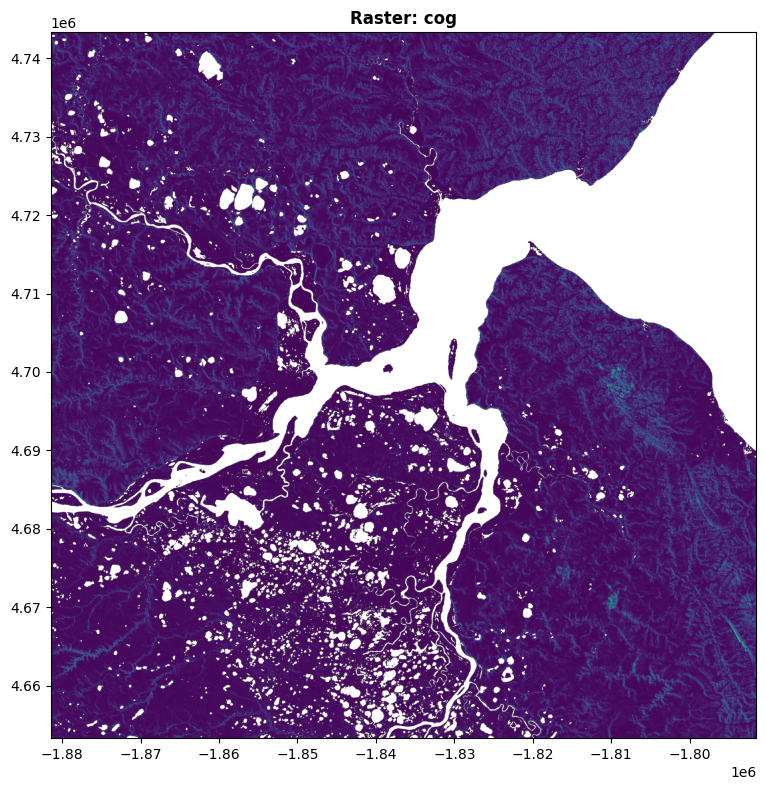

In [6]:
import json
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np

# Load croissant.json to get raster URL
with open("croissant.json", "r") as f:
    croissant_data = json.load(f)

# Extract the raster URL from distribution
raster_url = None
for dist in croissant_data.get("distribution", []):
    content_url = dist.get("contentUrl", "")
    if content_url.endswith(".tif") or "tif" in content_url:
        raster_url = content_url
        raster_name = dist.get("name", "unnamed")
        print(f"Found raster: {raster_name}")
        break

if not raster_url:
    print("No raster file found in croissant.json")
else:
    # Prepare URL for rasterio based on protocol
    if raster_url.startswith("s3://"):
        cog_url = raster_url.replace("s3://", "/vsis3/")
    elif raster_url.startswith("http://") or raster_url.startswith("https://"):
        cog_url = f"/vsicurl/{raster_url}"
    else:
        cog_url = raster_url
    
    print(f"Opening: {cog_url}")
    
    with rasterio.Env(AWS_NO_SIGN_REQUEST="YES"):
        with rasterio.open(cog_url) as src:
            print(f"CRS: {src.crs}")
            print(f"Bounds: {src.bounds}")
            print(f"Shape: {src.height} x {src.width}")
            print(f"Bands: {src.count}")
            
            # Read band statistics
            for i in range(1, src.count + 1):
                band = src.read(i, masked=True)
                mask = band.mask
                data = band.data
                
                valid_pixels = np.count_nonzero(~mask)
                
                print(f"\nBand {i} Stats:")
                if valid_pixels > 0:
                    print(f"  Min: {data[~mask].min():.2f}")
                    print(f"  Max: {data[~mask].max():.2f}")
                    print(f"  Mean: {data[~mask].mean():.2f}")
                else:
                    print("  No valid data")
            
            # Display the raster
            fig, ax = plt.subplots(figsize=(12, 8))
            show(src, ax=ax, title=f"Raster: {raster_name}")
            plt.tight_layout()
            plt.show()